# **Exam Project Supervised Learning** - June 2023 - Canesi Gabriele, Casati Rebecca





## **Classification with CNN**

### Training or not?



IMPORTANT: The code as it is will **not** perform the training of the net, it will download by itself the previously saved learned model and proceed with the evaluation.

On the contrary, if the user wants to perform the training, the value of the variable "Training" must be changed and set equal to "True", instead of "False".

In [37]:
Training = False

### Preliminary
All the necessary imports and libraries are here:

In [38]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy 
import glob
import os
import pickle 
import itertools
import io
import torchvision.transforms as transforms

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import confusion_matrix

To use the GPU:

In [39]:
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
DEVICE = torch.device("cuda:0" if train_on_gpu else "cpu")
print(DEVICE)

CUDA is available!  Training on GPU ...
cuda:0


Utility functions (needed to compute the accuracy and plot the confusion matrix):

In [40]:
# TOTAL ACCURACY
def compute_accuracy(confusion_matrix):
    # sum of the elements on the diagonal (trace of the matrix) (= correct predictions)
    diagonal_sum = np.trace(confusion_matrix)
    # sum of all the elements (= total predictions)
    total_sum = np.sum(confusion_matrix)
    # accuracy = correct predictions / all the predictions
    accuracy = diagonal_sum / total_sum
    return accuracy

# PLOT CONFUSION MATRIX
# second argument is a list of the class labels, to plot on the y and x axis of the matrix
def plot_confusionmatrix(confusion_mat, class_labels):
    fig5, ax = plt.subplots()

    # Create the heatmap
    heatmap = ax.imshow(confusion_mat, cmap='Blues')

    # Set the x-axis and y-axis labels 
    ax.set_xticks(range(0,100, 4))
    ax.set_yticks(range(0,100, 4))

    # Rotate the x-axis labels
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")

    # Add colorbar
    cbar = plt.colorbar(heatmap)

    # Set the title and axis labels
    ax.set_title('Confusion Matrix Heatmap')
    ax.set_xlabel('Predicted Classes')
    ax.set_ylabel('Actual Classes')
    
    # Show the plot
    plt.tight_layout()
    plt.savefig("Confusion_matrix.png")

### Import Dataset

Import and unzip the dataset:

In [41]:
!gdown "1wYs0vMlE7KuY5eABPCVRhgDpHEC8EviR"
!unzip -q -n "/content/TinyImageNet.zip" -d data 

Downloading...
From: https://drive.google.com/uc?id=1wYs0vMlE7KuY5eABPCVRhgDpHEC8EviR
To: /content/TinyImageNet.zip
100% 483M/483M [00:06<00:00, 77.5MB/s]


### Inspection of the data

Check in what color system are coded the images (they are all RGB):

In [42]:
# TRAIN SET
lst = glob.glob("/content/data/TinyImageNet/train/*/*.jpg")

# number of gray images in the train (train/val)
num_gray_train = 0
# number of RGB images in the train (train/val)
rgb_train = 0
# number of RGBA images in the train (train/val)
rgba_train = 0
# number of BGR (or other) images in the train (train/val)
bgr_train = 0

for pt in lst:
  im=Image.open(pt)
  bands = im.getbands()
  #print(bands)
  # increase the total number of gray images by one
  if len(bands) < 3:
    num_gray_train += 1
  # increase the total number of RGB images by one
  if im.mode == 'RGB':
    rgb_train += 1
  # increase the total number of RGBA images by one
  elif im.mode == 'RGBA':
    rgba_train += 1
  # increase the total number of BGR images by one
  else:
    bgr_train += 1


# VAL SET
lst = glob.glob("/content/data/TinyImageNet/val/*/*.jpg")

# number of gray images in the val (test)
num_gray_val = 0
# number of RGB images in the val (test)
rgb_val = 0
# number of RGBA images in the val (test)
rgba_val = 0
# number of BGR images in the val (test)
bgr_val = 0

for pt in lst:
  im=Image.open(pt)
  bands = im.getbands()
  if len(bands) < 3 :
    num_gray_train += 1
  if im.mode == 'RGB':
    rgb_val += 1
  elif im.mode == 'RGBA':
    rgba_val += 1
  else:
    bgr_val += 1

# print the results
# total number of gray images
print("Number of gray images in train:", num_gray_train)
print("Number of gray images in val:", num_gray_val)
# total number of RGB images
print("Number of RGB images in train:", rgb_train)
print("Number of RGB images in val:", rgb_val)
# total number of RGBA images
print("Number of RGBA images in train:", rgba_train)
print("Number of RGBA images in val:", rgba_val)
# total number of BGR images
print("Number of BGR or other images in train:", bgr_train)
print("Number of BGR or other images in val:", bgr_val)

Number of gray images in train: 0
Number of gray images in val: 0
Number of RGB images in train: 100000
Number of RGB images in val: 10000
Number of RGBA images in train: 0
Number of RGBA images in val: 0
Number of BGR or other images in train: 0
Number of BGR or other images in val: 0


### Load the dataset

Read and convert the data into Pandas Dataframe (we load only the train and validation file since the train data will be divided into train and validation, while the validation data will be used as test):



In [43]:
# read and convert into pandas dataframe
# train (saved as train and val)
df_train_val = pd.read_csv("/content/data/TinyImageNet/train.txt", sep = " ", header = None)
# val (saved as test)
df_test = pd.read_csv("/content/data/TinyImageNet/val.txt", sep = " ", header = None)

# rename the columns
df_train_val.columns = ["image", "label"]
df_test.columns = ["image", "label"]

Dataloader (documentation: [my dataloader](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#dataset-class)):

In [44]:
class TinyImageNetDataset(Dataset):
    """TinyImageNet dataset."""

    def __init__(self, ndarray, root_dir, transform = None):
        """
        Arguments:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data = ndarray
        # path
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name, label = self.data[idx]
        # open the image (PIL)
        image = Image.open(os.path.join(self.root_dir, img_name))
        # apply the transformations to the image
        image = self.transform(image)

        # the function returns a dictionary
        sample = {'image': image, 'label': torch.tensor(label)}
        return sample

Split the train set between training (80%) and validation (20%) with stratified sampling:

In [45]:
# initialize two empty pandas dataframe
df_train = pd.DataFrame()
df_val = pd.DataFrame()

# Proportional Split
# iteration over all the images of train set, with a step of 1000
# to get batches of 1000 elements (single class of the train set)
for i in range(0,100000,1000):
  # dataframe of the single class i (1000 images)
  df_class = df_train_val.loc[i:(i+999)]
  # random shuffle of the rows of the dataframe of the class i
  df_class = df_class.sample(frac=1).reset_index(drop=True)
  # split each class in two dataframes, one for train and one for validation
  train_df, val_df = train_test_split(df_class, test_size=0.2, random_state=42)
  # add the train and validation dataframe at the dataframes of the other classes
  df_train = pd.concat([df_train,train_df])
  df_val = pd.concat([df_val, val_df])

# Shuffle the new dataset
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_val = df_val.sample(frac=1).reset_index(drop=True)

# transformation to numpy array
df_train = df_train.to_numpy()
df_val = df_val.to_numpy()

Shuffle also the test set:

In [46]:
df_test = df_test.sample(frac=1).reset_index(drop=True)

# transformation to numpy array
df_test = df_test.to_numpy()

Transformations to the data, to pass to the dataloader:

In [47]:
# ONLY ONE TRANSFORMATION FOR TRAIN, VAL AND TEST
transform = transforms.Compose([            
    transforms.Resize((232, 232)),
    transforms.CenterCrop((224, 224)),                   
    transforms.ToTensor(),                     
    transforms.Normalize(                     
    mean=[0.485, 0.456, 0.406],               
    std=[0.229, 0.224, 0.225]                 
 )])

Create the train, validation and test set:

In [48]:
trainset = TinyImageNetDataset(df_train, "/content/data/TinyImageNet", transform)
valset = TinyImageNetDataset(df_val, "/content/data/TinyImageNet", transform)
testset = TinyImageNetDataset(df_test, "/content/data/TinyImageNet", transform)

Create the dataloader for training, validation and test set:

In [49]:
# batch size
bs = 16

trainloader = DataLoader(trainset, batch_size= bs, shuffle=True, num_workers = 0)
valloader = DataLoader(valset, batch_size= bs, shuffle=True, num_workers = 0)
testloader = DataLoader(testset, batch_size= 1, shuffle=False, num_workers = 0)

In [50]:
print(len(trainloader) * bs, len(valloader) * bs, len(testloader) * 1)

80000 20000 10000


### Model

Define the NN ([Models: pre-trained classification weights](https://pytorch.org/vision/main/models.html)):

In [51]:
# import the pretrained model
net = torchvision.models.regnet_x_1_6gf(weights='IMAGENET1K_V2') #weights=None for random weights **********
print(net)

RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 72, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 72, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(72, 72, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=3, bias=False)
            

Change the classifier of the net:

In [52]:
# number of features as output of the pre-trained model
num_ftrs = net.fc.in_features
# define the classifier
classifier = nn.Sequential(nn.Linear(num_ftrs, 500),
                               nn.ReLU(),
                               nn.Linear(500, 250),
                               nn.ReLU(),
                               # the output size is 100 since we have 100 classes
                               nn.Linear(250, 100)
                               )
#substitute the net classifier with the one just defined
#net.classifier = classifier
net.fc = classifier
# print our net
print(net)
net = net.to(DEVICE)

RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 72, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 72, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(72, 72, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=3, bias=False)
            

Freeze the parameters of the CNN in order to train only the classifier:

In [53]:
for key, value in dict(net.named_children()).items():
  #print(key)
  #if "classifier" in key:
  if "fc" in key:
    for param in value.parameters():
        param.requires_grad = True
        # print(param)
  else:
    for param in value.parameters():
        param.requires_grad = False
        # print(param)

Define Loss function and Optimizer:

In [54]:
# define the loss
criterion = nn.CrossEntropyLoss()
# define the optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)
#optimizer = optim.ASGD(net.parameters(), lr=0.001)
# define the scheduler
scheduler = CosineAnnealingLR(optimizer,
                              T_max = 100000, 
                              eta_min = 1e-5)

### Training (Transfer Learning)

Training and Validation:

In [55]:
if Training:
    # number of epochs
    N_epochs = 10

    best_model = None
    best_loss = np.inf
    patience = 8

    # list to save the validation loss values in order to plot them
    losses = []

    # lists to save the accuracy on training and validation set in order to plot them
    label_train = []
    predictions_train = []
    accuracy_train = []
    label_val = []
    predictions_val = []
    accuracy_val = []

    for epoch in range(N_epochs):
        running_loss = 0.0
        k=0
        net.train()
        for i, data in enumerate(trainloader):
            # get the inputs
            inputs, labels = data["image"], data["label"]
            labels = torch.tensor(labels, dtype= torch.int64)
            inputs=inputs.to(DEVICE)
            labels=labels.to(DEVICE)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = net(inputs)

            _, predicted_train = torch.max(outputs, 1)
            predictions_train.append(predicted_train.cpu())
            label_train.append(labels)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            k+=1
            # print statistics
            running_loss += loss.item()
            if (i % (len(trainloader)//10))==0: 
                print('[%d, %d] loss: %.4f' %
                    (epoch + 1, i + 1, running_loss / k))
                running_loss = 0.0
                k=0

        # transform the lists of tensor to lists of numbers
        label_train = torch.cat(label_train).tolist()
        predictions_train = torch.cat(predictions_train).tolist()

        confusion_mat = confusion_matrix(label_train, predictions_train)
        accuracy_train.append(compute_accuracy(confusion_mat))

        # empty the lists for the new epoch
        label_train = []
        predictions_train = []

        # pass to validation
        net.eval()
        k=0
        loss = 0
        with torch.no_grad():
            for i, data in enumerate(valloader):
                inputs, labels = data["image"], data["label"]
                labels = torch.tensor(labels, dtype= torch.int64)
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)
                outputs = net(inputs)
                outputs = outputs.to(DEVICE)

                _, predicted_val = torch.max(outputs, 1)
                predictions_val.append(predicted_val.cpu())
                label_val.append(labels)

                loss += criterion(outputs, labels)
                k += 1

            # transform the lists of tensor to lists of numbers
            label_val = torch.cat(label_val).tolist()
            predictions_val = torch.cat(predictions_val).tolist()

            confusion_mat = confusion_matrix(label_val, predictions_val)
            accuracy_val.append(compute_accuracy(confusion_mat)) 

            # empty the lists for the new epoch
            label_val = []
            predictions_val = []  

            if loss < best_loss:
                best_loss = loss
                # save the best model
                #torch.save(net.state_dict(), "best_net.pth")
                patience = 8
                print("**BEST**", end= "")
            else:
                # decrease the patience
                patience -= 1 
            print("Epoch %d: Cross-entropy: %.4f" % (epoch, loss/k))
            # pass the value of the loss to cpu in order to put it in the list losses
            loss = loss.cpu()
            losses.append(loss/k)
            if patience <= 0:
                # stop the training
                break

            # save the model
            torch.save(net.state_dict(), "net.pth")

    print('Finished Training')

Loss trend with the number of epochs (print the graph) (only if the training is performed):

In [56]:
if Training:
    fig1 = plt.figure(figsize = (16,9))

    # plot
    plt.plot(range(0,10), losses, marker = "o", linestyle = "-")

    # axis options
    plt.xlabel("No. of epoch")
    plt.ylabel("Validation Loss")
    plt.xticks(range(0,10))
    plt.grid()
    plt.title("Loss vs Number of epochs")

    plt.savefig("Loss.png")
    plt.show()

Plot of Training and Validation Accuracy with the number of epochs:

In [57]:
if Training:
    fig2 = plt.figure(figsize = (16,9))

    # plot
    plt.plot(range(0,10), accuracy_train, marker = "o", linestyle = "-", color = 'red', label = "Training accuracy")
    plt.plot(range(0,10), accuracy_val, marker = "o", linestyle = "-", color = 'blue', label = "Validation Accuracy")

    # axis options
    plt.xlabel("No. of epoch")
    plt.ylabel("Accuracy")
    plt.xticks(range(0,10))
    plt.legend()
    plt.grid()
    plt.title("Train and Validation Accuracy vs Number of epochs")

    plt.savefig("Train_Val_Accuracy.png")
    plt.show()

Load the model (already saved) when not performing the training of the net:

In [58]:
if Training == False:
    # download the model
    !gdown "1yAtfwSRK_fOKYEdP1v4YHk6dCtYsyqfa"
    # load the model
    net.load_state_dict(torch.load('net.pth'))

Downloading...
From: https://drive.google.com/uc?id=1yAtfwSRK_fOKYEdP1v4YHk6dCtYsyqfa
To: /content/net.pth
100% 35.8M/35.8M [00:00<00:00, 140MB/s]


### Evaluation
Evaluate the performance of the model (on the test set).

Get true labels and predicted ones on the test set:

In [59]:
# get the ground truth labels of the test images
label_test = []
# get the predictions on the test images
predictions = []

net.eval()

for i, data in enumerate(testloader):
  image, label = data["image"], data["label"]
  label_test.append(label)
  image=image.to(DEVICE)
  output = net(image)
  _, predicted = torch.max(output, 1)
  predictions.append(predicted.cpu())

# transform the lists of tensor to lists of numbers
label_test = [l.item() for l in label_test]
predictions = [p.item() for p in predictions]
#print(label_test)
#print(predictions)

Compute the Confusion Matrix:

In [60]:
confusion_mat = confusion_matrix(label_test, predictions)

Plot the Confusion Matrix:

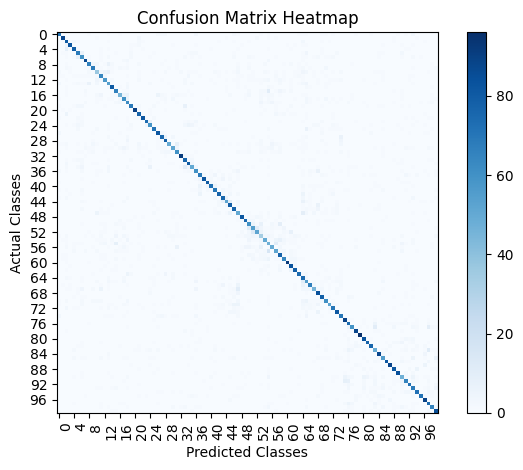

In [61]:
# range(100) contains the labels of the classes (which are the numbers from 0 to 99)
plot_confusionmatrix(confusion_mat, range(100))

Total Accuracy:

In [62]:
accuracy = compute_accuracy(confusion_mat)
print("The total accuracy is %.f%%" %(accuracy*100))

The total accuracy is 70%


Accuracy per class:

In [63]:
# list of 100 elements in which the element i contain the number of correct predictions...
# that the model made of that class
class_correct = []
# list of 100 elements in which the element i contain the total number of predictions...
# that the model made of that class
class_total = []
# labels of the classes
classes = np.arange(100)
# list of accuracies for each class
accuracy_classes = []

for i in range(100):
  vertical_array = confusion_mat[:, i]
  # the sum of the vertical_array is the total number of times that the class was predicted
  class_total.append(np.sum(vertical_array))
  # the i-th element of the vertical_array is the element (i,i) on the diagonal...
  # of the confusion matrix, which is the number of correct predictions of the class i
  class_correct.append(vertical_array[i])

for i in range(100):
    accuracy_classes.append(100 * class_correct[i] / class_total[i])
    print('Accuracy of %5s : %2d %%' % (
        classes[i], accuracy_classes[i]))

Accuracy of     0 : 73 %
Accuracy of     1 : 90 %
Accuracy of     2 : 56 %
Accuracy of     3 : 89 %
Accuracy of     4 : 79 %
Accuracy of     5 : 66 %
Accuracy of     6 : 52 %
Accuracy of     7 : 82 %
Accuracy of     8 : 77 %
Accuracy of     9 : 75 %
Accuracy of    10 : 50 %
Accuracy of    11 : 59 %
Accuracy of    12 : 70 %
Accuracy of    13 : 49 %
Accuracy of    14 : 78 %
Accuracy of    15 : 66 %
Accuracy of    16 : 68 %
Accuracy of    17 : 59 %
Accuracy of    18 : 48 %
Accuracy of    19 : 79 %
Accuracy of    20 : 94 %
Accuracy of    21 : 67 %
Accuracy of    22 : 90 %
Accuracy of    23 : 88 %
Accuracy of    24 : 64 %
Accuracy of    25 : 78 %
Accuracy of    26 : 75 %
Accuracy of    27 : 79 %
Accuracy of    28 : 72 %
Accuracy of    29 : 75 %
Accuracy of    30 : 63 %
Accuracy of    31 : 66 %
Accuracy of    32 : 90 %
Accuracy of    33 : 63 %
Accuracy of    34 : 76 %
Accuracy of    35 : 60 %
Accuracy of    36 : 60 %
Accuracy of    37 : 69 %
Accuracy of    38 : 92 %
Accuracy of    39 : 86 %


Bar chart of class accuracies:

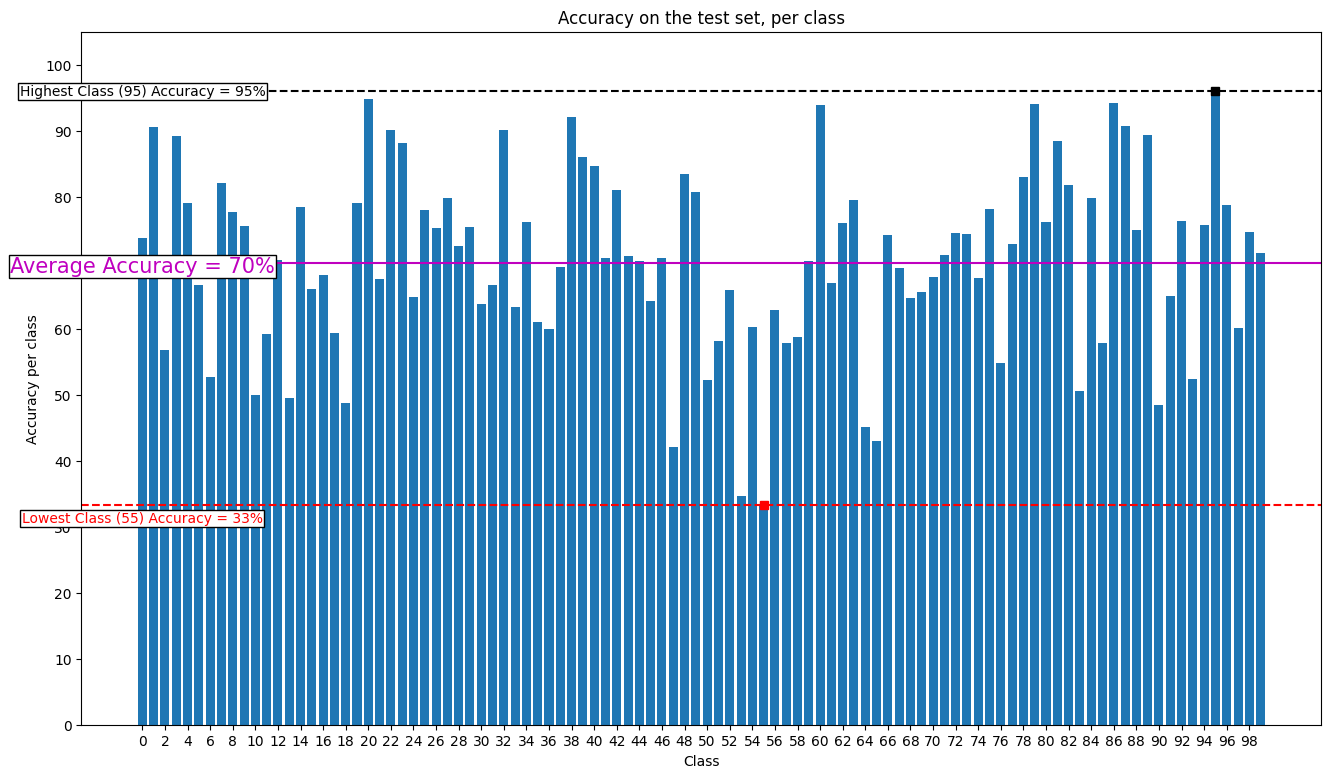

In [64]:
fig3 = plt.figure(figsize = (16,9))

# bar chart
plt.bar(classes, accuracy_classes, align = "center")

# axis options
plt.xlabel("Class")
plt.ylabel("Accuracy per class")
plt.xticks(range(0,100, 2))
plt.yticks(range(0,105, 10))
plt.ylim(0,105)
#plt.grid()
plt.title("Accuracy on the test set, per class")

# assign the values
average_accuracy = 70
lowest_class = 55
highest_class = 95

# lines
plt.axhline(y = average_accuracy, color='m', linestyle='solid')
plt.axhline(y = accuracy_classes[lowest_class], color='r', linestyle='--')
plt.axhline(y = accuracy_classes[highest_class], color='k', linestyle='--')

# dots
plt.plot(lowest_class, accuracy_classes[lowest_class], 's', color='r')
plt.plot(highest_class, accuracy_classes[highest_class], 's', color='k')

# texts
plt.text(0, average_accuracy+1, 'Average Accuracy = 70%', fontsize=15, color='m',
         verticalalignment ='top', 
         horizontalalignment ='center',
         bbox ={'facecolor':'white', 
                'pad':1})
plt.text(0, accuracy_classes[lowest_class]-1, 'Lowest Class (55) Accuracy = 33%', fontsize=10, color='r',
         verticalalignment ='top', 
         horizontalalignment ='center',
         bbox ={'facecolor':'white', 
                'pad':1})
plt.text(0, accuracy_classes[highest_class]+1, 'Highest Class (95) Accuracy = 95%', fontsize=10, color='k',
         verticalalignment ='top', 
         horizontalalignment ='center',
         bbox ={'facecolor':'white', 
                'pad':1})

plt.savefig("Accuracies.png")
plt.show()

### Diffusion

Last evaluation step: 11 images, generated with diffusion models and representing two animals together that belong to two different classes (dog and cat), are classified by the trained model.

Download and unzip the dataset (11 images):

In [65]:
!gdown "1OfD1CRHsSIei_VaYGfRG5A7Sbh6kNOU8"
!unzip -q -n "/content/Testing_diffusion.zip" -d data

Downloading...
From: https://drive.google.com/uc?id=1OfD1CRHsSIei_VaYGfRG5A7Sbh6kNOU8
To: /content/Testing_diffusion.zip
100% 853k/853k [00:00<00:00, 135MB/s]


Import data and create data loader:

In [66]:
# read the dataset with the 11 generated images as a pandas dataframe
df_testing_diff = pd.read_csv("/content/data/Testing_diffusion/testing_diffusion.txt", sep = " ", header = None,encoding="utf-16")
# drop the third column (NaN)
df_testing_diff = df_testing_diff.drop([2], axis=1)
# rename the columns
df_testing_diff.columns = ["image", "label"]

# convert in numpy array
df_testing_diff = df_testing_diff.to_numpy()
df_testing_diff[:, 1] = df_testing_diff[:, 1].astype(float)

In [67]:
# create train, validation and test set
diff_set = TinyImageNetDataset(df_testing_diff,"/content/data",transform)

diffloader = torch.utils.data.DataLoader(diff_set, batch_size = 1,
                                          shuffle = False, num_workers = 0)

# print the dimension of the train, validation and test set
print(len(diffloader))

11


Evaluation of the images with the model:

In [68]:
dataiter = iter(diffloader)
images=[]
classes = (np.arange(100))
net.eval()
for i in range(11): 
  image = next(dataiter)['image']
  images.append(image)
  with torch.no_grad():
    image=image.to(DEVICE)
    output=net(image)
  _, pred= torch.max(output.cpu(), 1) #take the maximum of the argument
  smax=torch.nn.Softmax(dim=1)(output.cpu()) # softmax converts this numbers to prob, the summ of alll vlaues is equal to 1 
  top_p, top_class = smax.topk(3, dim = 1) # which are the top three prob predicted                  
  top_class=[classes[id] for id in top_class.squeeze()]
  print(f"GroundTruth: from 37 to 42 \n\tPredicted: {classes[pred]}\n\tClasses: {top_class}\n\tProbs: {top_p.squeeze().numpy()}" )

GroundTruth: from 37 to 42 
	Predicted: 38
	Classes: [38, 39, 45]
	Probs: [0.9834764  0.00629687 0.00515717]
GroundTruth: from 37 to 42 
	Predicted: 39
	Classes: [39, 75, 37]
	Probs: [0.54049474 0.10752804 0.06935412]
GroundTruth: from 37 to 42 
	Predicted: 40
	Classes: [40, 91, 37]
	Probs: [0.31348595 0.20663531 0.06580366]
GroundTruth: from 37 to 42 
	Predicted: 91
	Classes: [91, 44, 37]
	Probs: [0.45587733 0.10437541 0.06799232]
GroundTruth: from 37 to 42 
	Predicted: 37
	Classes: [37, 91, 43]
	Probs: [0.83521956 0.1010028  0.0061321 ]
GroundTruth: from 37 to 42 
	Predicted: 38
	Classes: [38, 91, 37]
	Probs: [9.99077082e-01 3.59548372e-04 1.16420924e-04]
GroundTruth: from 37 to 42 
	Predicted: 91
	Classes: [91, 75, 37]
	Probs: [0.96512425 0.02829202 0.00155958]
GroundTruth: from 37 to 42 
	Predicted: 37
	Classes: [37, 38, 91]
	Probs: [0.9815978  0.00989348 0.00376644]
GroundTruth: from 37 to 42 
	Predicted: 38
	Classes: [38, 37, 91]
	Probs: [0.97093403 0.00849947 0.00588541]
GroundT